In [ ]:
!pip uninstall yfinance
!pip install yfinance==0.2.28

In [ ]:
!/bin/python3
import pandas as pd
import numpy as np
from pandas_datareader import data
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def load_financial_data(start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', start_date, end_date)
        df.to_pickle(output_file)
    return df

goog_data=load_financial_data(start_date='2001-01-01',
                    end_date = '2018-01-01',
                    output_file='goog_data.pkl')





In [3]:
goog_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...
2017-12-22,53.055500,53.209999,52.972000,53.006001,53.006001,15102000
2017-12-26,52.903500,53.006001,52.509998,52.837002,52.837002,15212000
2017-12-27,52.869499,52.918499,52.402500,52.468498,52.468498,25438000


In [ ]:
def linear(data):
    signals = pd.DataFrame(index=data.index)
    signals['p1'] = data['High']-data['High']
    signals['p1'] = data['Open']-data['Close']
    signals['p3'] = data['Volume']
    
    X = signals[['p1','p2','p3']][:-1]
    y = signals[['price']].shift(-1)[:-1]
    
    
    model = LinearRegression()
    model.fit(X,y)
    
    signals['predict']=np.nan
    signals['predict'][:-1] = model.predict(X)
    signals['signal'] = 0.0
    signals['signal'][:-1] = np.where(signals['predict'][:-1] > signals['price'][:-1],1.0,-1.0)
    signals['orders'] = signals['signal'].diff()

In [4]:
def random_data(financial_data):
    signals = pd.DataFrame(index=financial_data.index)
    data = np.random.randint(0, 2, size=financial_data.shape[0])

    signals['signal'] = data # position
    #00000011111111110000000000 # position
    #000000100000000-1000000000 # orders
    signals['orders'] = signals['signal'].diff() # orders
    return signals


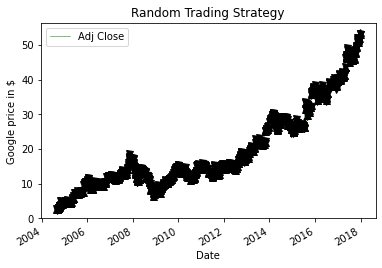

In [5]:
ts=random_data(goog_data)
signals=ts
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)

ax1.plot(ts.loc[ts.orders== 1.0].index,
         goog_data["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         goog_data["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')
plt.legend()
plt.title("Random Trading Strategy")

plt.show()


                  GOOG    holdings          cash         total   returns
Date                                                                    
2004-08-19    0.000000    0.000000  10000.000000  10000.000000       NaN
2004-08-20    0.000000    0.000000  10000.000000  10000.000000  0.000000
2004-08-23    0.000000    0.000000  10000.000000  10000.000000  0.000000
2004-08-24   26.119599   26.119599   9973.880401  10000.000000  0.000000
2004-08-25    0.000000    0.000000  10000.281441  10000.281441  0.000028
...                ...         ...           ...           ...       ...
2017-12-22  530.060005  530.060005   9596.656704  10126.716709  0.000000
2017-12-26  528.370018  528.370018   9596.656704  10125.026722 -0.000167
2017-12-27  524.684982  524.684982   9596.656704  10121.341686 -0.000364
2017-12-28  524.070015  524.070015   9596.656704  10120.726719 -0.000061
2017-12-29  523.199997  523.199997   9596.656704  10119.856701 -0.000086

[3366 rows x 5 columns]


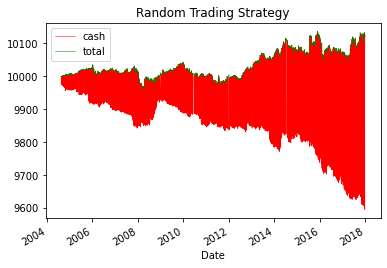

In [6]:
# You are going to set your initial amount of money you want
# to invest --- here it is 10,000
initial_capital = float(10000.0)

# You are going to create a new dataframe positions
# Remember the index is still the same as signals
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# You are going to buy 10 shares of MSFT when signal is 1
# You are going to sell 10 shares of MSFT when signal is -1
# You will assign these values to the column MSFT of the
# dataframe positions
positions['GOOG'] = 10 * ts['signal']

# You are now going to calculate the notional (quantity x price)
# for your portfolio. You will multiply Adj Close from
# the dataframe containing prices and the positions (10 shares)
# You will store it into the variable portfolio
portfolio = positions.multiply(goog_data['Adj Close'], axis=0)

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(goog_data['Adj Close'], axis=0)).sum(axis=1)

# You will store positions.diff into pos_diff
pos_diff = positions.diff()
# You will now add a column cash in your dataframe portfolio
# which will calculate the amount of cash you have
# initial_capital - (the notional you use for your different buy/sell)
portfolio['cash'] = initial_capital - (pos_diff.multiply(goog_data['Adj Close'], axis=0)).sum(axis=1).cumsum()

# You will now add a column total to your portfolio calculating the part of holding
# and the part of cash
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio)
#portfolio.plot( color='g', lw=.5)

# portfolio['holdings'].plot( color='g', lw=.5)
portfolio['cash'].plot( color='r', lw=.5)
portfolio['total'].plot( color='g', lw=.5)
plt.title("Random Trading Strategy")
plt.legend()
plt.show()

In [7]:
def one_trade(financial_data):
    signals = pd.DataFrame(index=financial_data.index)
    data = np.ones(financial_data.shape[0])
    data[0]=0
    data[financial_data.shape[0]-1] = 0

    signals['signal'] = data # position
    #00000011111111110000000000 # position
    #000000100000000-1000000000 # orders
    signals['orders'] = signals['signal'].diff() # orders
    return signals


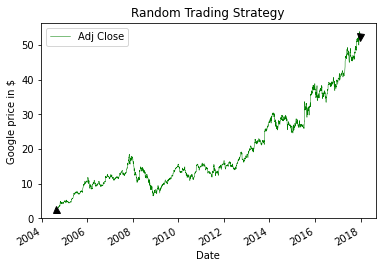

In [8]:
ts=one_trade(goog_data)
signals=ts
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)

ax1.plot(ts.loc[ts.orders== 1.0].index,
         goog_data["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         goog_data["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')
plt.legend()
plt.title("Random Trading Strategy")

plt.show()


                  GOOG    holdings          cash         total   returns
Date                                                                    
2004-08-19    0.000000    0.000000  10000.000000  10000.000000       NaN
2004-08-20   26.976390   26.976390   9973.023610  10000.000000  0.000000
2004-08-23   27.247870   27.247870   9973.023610  10000.271480  0.000027
2004-08-24   26.119599   26.119599   9973.023610   9999.143209 -0.000113
2004-08-25   26.401041   26.401041   9973.023610   9999.424651  0.000028
...                ...         ...           ...           ...       ...
2017-12-22  530.060005  530.060005   9973.023610  10503.083615 -0.000167
2017-12-26  528.370018  528.370018   9973.023610  10501.393628 -0.000161
2017-12-27  524.684982  524.684982   9973.023610  10497.708592 -0.000351
2017-12-28  524.070015  524.070015   9973.023610  10497.093625 -0.000059
2017-12-29    0.000000    0.000000  10496.223607  10496.223607 -0.000083

[3366 rows x 5 columns]


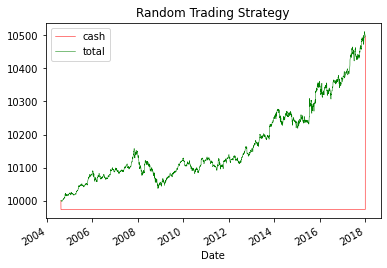

In [9]:
# You are going to set your initial amount of money you want
# to invest --- here it is 10,000
initial_capital = float(10000.0)

# You are going to create a new dataframe positions
# Remember the index is still the same as signals
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# You are going to buy 10 shares of MSFT when signal is 1
# You are going to sell 10 shares of MSFT when signal is -1
# You will assign these values to the column MSFT of the
# dataframe positions
positions['GOOG'] = 10 * ts['signal']

# You are now going to calculate the notional (quantity x price)
# for your portfolio. You will multiply Adj Close from
# the dataframe containing prices and the positions (10 shares)
# You will store it into the variable portfolio
portfolio = positions.multiply(goog_data['Adj Close'], axis=0)

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(goog_data['Adj Close'], axis=0)).sum(axis=1)

# You will store positions.diff into pos_diff
pos_diff = positions.diff()
# You will now add a column cash in your dataframe portfolio
# which will calculate the amount of cash you have
# initial_capital - (the notional you use for your different buy/sell)
portfolio['cash'] = initial_capital - (pos_diff.multiply(goog_data['Adj Close'], axis=0)).sum(axis=1).cumsum()

# You will now add a column total to your portfolio calculating the part of holding
# and the part of cash
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio)
#portfolio.plot( color='g', lw=.5)

# portfolio['holdings'].plot( color='g', lw=.5)
portfolio['cash'].plot( color='r', lw=.5)
portfolio['total'].plot( color='g', lw=.5)
plt.title("Random Trading Strategy")
plt.legend()
plt.show()